In [2]:
import time, os
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
import csv
import pandas as pd
import re
import numpy as np

'''
Authenticate
'''
key = '545da291833e4c21b6af2376917b30f5'
endpoint = 'https://mcritextextract.cognitiveservices.azure.com/'

# Set credentials
credentials = CognitiveServicesCredentials(key)
# Create client
client = ComputerVisionClient(endpoint, credentials)


'''
Read and extract from the image
'''
    
def pdf_text(filename):
    # Images PDF with text

    filepath = open(filename,'rb')

    # Async SDK call that "reads" the image
    response = client.read_in_stream(filepath, raw=True)

    # Don't forget to close the file
    filepath.close()

    # Get ID from returned headers
    operation_location = response.headers["Operation-Location"]
    operation_id = operation_location.split("/")[-1]

    # SDK call that gets what is read
    while True:
        result = client.get_read_result(operation_id)
        if result.status.lower () not in ['notstarted', 'running']:
            break
        #print ('Waiting for result...')
        time.sleep(10)
    return result


'''
Creating csv files of extracted text
'''
def create_output(filename, num_samples):
    for i in range(num_samples):
        result = pdf_text(filename+str(i+1)+'.png')
        output = []
        output.append(('Text', 'Confidence'))
        if result.status == OperationStatusCodes.succeeded:
            for readResult in result.analyze_result.read_results:
                for line in readResult.lines:
                    #print(line.text)
                    for word in line.words:
                        output.append((word.text, word.confidence))

            with open(filename+str(i+1)+'_output.csv', "a", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerows(output)
            f.close()
            
samples_medium = 3
samples_bad = 3
samples_good = 4

filename_medium = 'mediumchart_'
filename_bad = 'badchart_'
filename_good = 'goodchart_'
#medium handwriting quality
create_output(filename_medium, samples_medium)
#bad handwriting quality
create_output(filename_bad, samples_bad)
#good handwriting quality
create_output(filename_good, samples_good)

In [17]:
def extract_all_zones(filename, num_samples):
    #extracted_list = []
    comparison_df_list = []

    for k in range(num_samples):
        output_df = pd.read_csv(filename+str(k+1)+'_output.csv')

        #Zone 1 (Patient information)
        fields = ['URN', 'Family', 'Given', 'Address', 'Birth', 'Sex']
        extracted = {key: None for key in fields}
        confidence = []

        for i, key in enumerate(fields): 
            if i == 1 or i == 2:
                index = (output_df.index[output_df['Text'].str.contains(key, case=False)] + 2)[0]
                extracted[key] = output_df.iloc[index]['Text']
                confidence.append(output_df.iloc[index]['Confidence'])
            else:
                try:
                    index = (output_df.index[output_df['Text'].str.contains(key, case=False)] + 1)[0]
                    extracted[key] = output_df.iloc[index]['Text']
                    confidence.append(output_df.iloc[index]['Confidence'])
                except IndexError:
                    extracted[key] = ' '
                    confidence.append(0)
            

        #Zone 2 (Medication information)
        medication_fields = ['Date', 'Medicine', 'Route', 'Dose', 'Indication', 'Prescriber']

        for i, key in enumerate(medication_fields):
            if i == 0:
                index = (output_df.index[output_df['Text'].str.contains('generic', case=False)] + (i+2))[0]
            elif i == 1:
                index_start = (output_df.index[output_df['Text'].str.contains('generic', case=False)] + (i+2))[0]
                index_end = (output_df.index[output_df['Text'].str.contains('Date', case=False)])[2]
                value = ""
                for j in range(index_start, index_end):
                    value += output_df.iloc[j]['Text'] + ' '
                extracted[key] = value.strip()
                confidence.append(output_df.iloc[index_start]['Confidence'])
            elif i == 2:
                    index = (output_df.index[output_df['Text'].str.contains('hrs', case=False)] + 1)[0]
            elif i == 3:
                extracted[key] = output_df.iloc[index + 1]['Text'] + ' ' + output_df.iloc[index + 2]['Text']
                confidence.append(output_df.iloc[index + 1]['Confidence'])
            elif i == 4:
                index_start = (output_df.index[output_df['Text'].str.contains('indication', case=False)])[0]
                index_end = (output_df.index[output_df['Text'].str.contains('pharmacy', case=False)])[0]
                value = ""
                for j in range(index_start+1, index_end):
                    value += output_df.iloc[j]['Text'] + ' '
                extracted[key] = value.strip()
                confidence.append(output_df.iloc[index_start + 1]['Confidence'])
            elif i == 5:
                index = (output_df.index[output_df['Text'].str.contains('contact', case=False)] + 1)[0]
                extracted[key] = output_df.iloc[index]['Text'] + ' ' + output_df.iloc[index + 1]['Text']
                confidence.append(output_df.iloc[index]['Confidence'])

            if i == 0 or i == 2:
                extracted[key] = output_df.iloc[index]['Text']
                confidence.append(output_df.iloc[index]['Confidence'])

        #Zone 3 (Dosage information)
        dosage_fields = ['Date1', 'Date2', 'Time1', 'Time2', 'Dose1', 'Dose2', 'Route1', 'Route2']

        for i, key in enumerate(dosage_fields):
            if i == 0:
                index = (output_df.index[output_df['Text'].str.contains('yes', case=False)] - 1)[0]
                split_date = output_df.iloc[index]['Text'].split("/", 2)
                dates = "/".join(split_date[:2]), "/".join(split_date[2:])
                extracted[key] = dates[i]
                confidence.append(output_df.iloc[index]['Confidence'])
            elif i == 1:
                extracted[key] = dates[i]
                confidence.append(output_df.iloc[index]['Confidence'])
            elif i == 2:
                index = (output_df.index[output_df['Text'].str.contains('time', case=False)])[0]
                extracted[key] = output_df.iloc[index+1]['Text']
                confidence.append(output_df.iloc[index+1]['Confidence'])
            elif i == 3:
                extracted[key] = output_df.iloc[index+2]['Text']
                confidence.append(output_df.iloc[index+2]['Confidence'])
            elif i == 4:
                index = (output_df.index[output_df['Text'].str.contains('pharmacy', case=False)])[0]
                extracted[key] = output_df.iloc[index+2]['Text']
                confidence.append(output_df.iloc[index+2]['Confidence'])
            elif i == 5:
                extracted[key] = output_df.iloc[index+3]['Text']
                confidence.append(output_df.iloc[index+3]['Confidence'])
            elif i == 6:
                index = (output_df.index[output_df['Text'].str.contains('route', case=False)])[1]
                route = output_df.iloc[index+1]['Text']
                match= re.match(r'(.*?)(?:\1)*$', route)
                word= match.group(1)
                extracted[key] = word
                confidence.append(output_df.iloc[index+1]['Confidence'])
            elif i == 7:
                extracted[key] = word
                confidence.append(output_df.iloc[index+1]['Confidence'])

        #print(extracted)
        #print(confidence)
        comparison_df = pd.read_csv(filename+str(k+1)+'_truelabels.csv')
        comparison_df['Extracted'] = list(extracted.values())
        comparison_column = np.where(comparison_df["Ground Truth"].str.lower() == comparison_df["Extracted"].str.lower(), 1, 0)
        comparison_df['match'] = comparison_column
        comparison_df['confidence'] = confidence

        #extracted_list.append(extracted)
        comparison_df_list.append(comparison_df)
        
    return comparison_df_list


comparison_df_medium = extract_all_zones(filename_medium, samples_medium)
comparison_df_bad = extract_all_zones(filename_bad, samples_bad)
comparison_df_good = extract_all_zones(filename_good, samples_good)

In [18]:
def get_accuracy(comparison_df_list, num_samples):
    accuracy_df = comparison_df_list[0].loc[:, ['Field']]
    accuracy_df['Sum matches'] = 0
    for df in comparison_df_list:
        accuracy_df['Sum matches'] += df['match'] 

    accuracy_df['Accuracy'] = accuracy_df['Sum matches']/num_samples
    
    return accuracy_df

accuracy_df_medium = get_accuracy(comparison_df_medium, samples_medium)
accuracy_df_bad = get_accuracy(comparison_df_bad, samples_bad)
accuracy_df_good = get_accuracy(comparison_df_good, samples_good)

In [19]:
def get_contingency(comparison_df_list, threshold):
    field_names = comparison_df_list[0]['Field'].tolist()
    merged_cols = pd.DataFrame(columns = ['Confidence', 'TF'])
    index = 0

    for name in field_names:
        for df in comparison_df_list:
            confidence_score = df.loc[df['Field'] == name, 'confidence'].iloc[0]
            TF = df.loc[df['Field'] == name, 'match'].iloc[0]
            merged_cols.loc[index] = [confidence_score] + [TF]
            index += 1

    return pd.crosstab(merged_cols['Confidence'].astype(float) > threshold , \
                           (merged_cols['TF'] == 1), \
                           rownames=['90'], colnames=['actual'])

contingency_medium = get_contingency(comparison_df_medium, 0.9)
contingency_bad = get_contingency(comparison_df_bad, 0.9)
contingency_good = get_contingency(comparison_df_good, 0.9)

In [20]:
contingency_medium

actual,False,True
90,,
False,19,8
True,14,19


In [21]:
contingency_bad

actual,False,True
90,,
False,22,8
True,17,13


In [22]:
contingency_good

actual,False,True
90,,
False,21,7
True,19,33


In [23]:
#Sensitivity = TP / (TP + FN)
#Specificity = TN / (FP + TN)
#PPV = TP / (TP + FP)
#NPV = TN / (TN + FN)

#medium quality
sensitivity_medium = 19 / (19 + 8)
specificity_medium = 19 / (19 + 14)
PPV_medium = 19 / (19 + 14)
NPV_medium = 19 / (19 + 8)
accuracy_medium = accuracy_df_medium['Accuracy'].mean()

#Bad quality
sensitivity_bad = 13 / (13 + 8)
specificity_bad = 22 / (22 + 17)
PPV_bad = 13 / (13 + 17)
NPV_bad = 22 / (22 + 8)
accuracy_bad = accuracy_df_bad['Accuracy'].mean()

#Good quality
sensitivity_good = 33 / (33 + 7)
specificity_good = 21 / (21 + 19)
PPV_good = 33 / (33 + 19)
NPV_good = 21 / (21 + 7)
accuracy_good = accuracy_df_good['Accuracy'].mean()

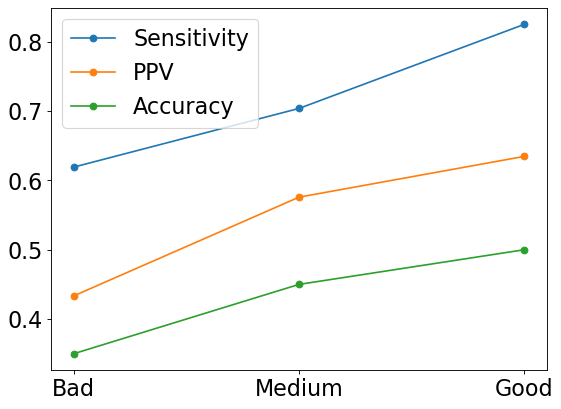

In [32]:
import matplotlib.pyplot as plt

category = ['Bad', 'Medium', 'Good']

Sensitivity = [sensitivity_bad, sensitivity_medium, sensitivity_good]
Specificity = [specificity_bad, specificity_medium, specificity_good]
PPV = [PPV_bad, PPV_medium, PPV_good]
NPV = [NPV_bad, NPV_medium, NPV_good]
Accuracy = [accuracy_bad, accuracy_medium, accuracy_good]

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(category, Sensitivity, marker='o')
plt.plot(category, PPV, marker='o')
plt.plot(category, Accuracy, marker='o')

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.legend(['Sensitivity', 'PPV', 'Accuracy'], prop={'size': 20})
#plt.savefig('./recognization_stats/positive.jpg', format='jpg')

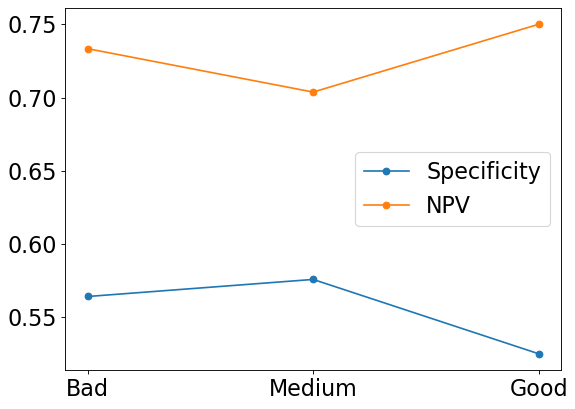

In [25]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(category, Specificity, marker='o')
plt.plot(category, NPV, marker='o')

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.legend(['Specificity', 'NPV'], prop={'size': 20})
#plt.savefig('./recognization_stats/negative.jpg', format='jpg')